In [1]:
import pandas as pd
from src import *

# Read Data

In [2]:
start_date = datetime(2007, 1, 1)

predicted_returns = pd.read_pickle("data/pred_ret_Least Correlated 15.pkl")
predicted_returns = predicted_returns.loc[start_date:].unstack("ticker")
predicted_returns

predicted_ret                                                    \
ticker                 A       AAL       ABT      ADBE       ADI       ADM   
2007-01-31     -0.002133  0.035175  0.025237  0.020707  0.011429  0.034090   
2007-02-28      0.043996 -0.012822  0.040074       NaN  0.023886 -0.001054   
2007-03-31           NaN       NaN  0.015672       NaN       NaN  0.014073   
2007-04-30           NaN       NaN  0.048433       NaN       NaN  0.052484   
2007-05-31           NaN       NaN  0.022859       NaN       NaN  0.016599   
...                  ...       ...       ...       ...       ...       ...   
2023-10-31     -0.043311 -0.042693 -0.042277       NaN -0.056070 -0.062847   
2023-11-30      0.072072  0.075216  0.086401       NaN  0.074003  0.067054   
2023-12-31      0.023622  0.151895  0.082712       NaN  0.085269  0.068023   
2024-01-31           NaN -0.027582 -0.002527       NaN       NaN -0.002661   
2024-02-29           NaN  0.037534  0.038792       NaN       NaN  0.006177   

                                                    ...                      \
ticker           ADP      ADSK       AEE       AEP  ...      FOXA       DOW   
2007-01-31  0.018268  0.031970  0.018434  0.015443  ...       NaN       NaN   
2007-02-28       NaN  0.051159  0.031737  0.028373  ...       NaN       NaN   
2007-03-31       NaN       NaN -0.031169  0.033459  ...       NaN       NaN   
2007-04-30       NaN       NaN  0.058828  0.059521  ...       NaN       NaN   
2007-05-31  0.024130       NaN  0.026350  0.025448  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2023-10-31       NaN -0.041854 -0.021653 -0.036897  ... -0.068694 -0.076189   
2023-11-30       NaN  0.107709  0.077041  0.067832  ...  0.081136  0.070214   
2023-12-31       NaN  0.057701  0.076830  0.076717  ...  0.099976  0.061205   
2024-01-31       NaN       NaN -0.037944 -0.027516  ... -0.019718 -0.023727   
2024-02-29       NaN       NaN  0.001527  0.011308  ...  0.013449  0.027115   

                                                                        \
ticker          AMCR       LHX      CTVA        TT      CARR ABNB UBER   
2007-01-31       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
2007-02-28       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
2007-03-31       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
2007-04-30       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
2007-05-31       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
...              ...       ...       ...       ...       ...  ...  ...   
2023-10-31 -0.041470 -0.052726 -0.082733 -0.033050 -0.045510  NaN  NaN   
2023-11-30  0.084635  0.075081  0.062435  0.071631  0.067034  NaN  NaN   
2023-12-31  0.079035  0.050126  0.110213  0.039771  0.078074  NaN  NaN   
2024-01-31 -0.018701  0.005385 -0.020946  0.039493 -0.005979  NaN  NaN   
2024-02-29  0.009945  0.073000  0.054400  0.082947  0.055485  NaN  NaN   

                      
ticker           CEG  
2007-01-31       NaN  
2007-02-28       NaN  
2007-03-31       NaN  
2007-04-30       NaN  
2007-05-31       NaN  
...              ...  
2023-10-31 -0.042706  
2023-11-30  0.072967  
2023-12-31  0.000445  
2024-01-31  0.015750  
2024-02-29  0.142096  

[206 rows x 377 columns]

In [3]:
price = pd.read_pickle("data/price.pkl")["adj_close"].unstack("ticker")
price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

# Find top / bottom decile for long / short position

In [4]:
s_sector = (get_zacks(use_cache=True)["zacks_sector_code"]
            .groupby("ticker").last())
s_sector

ticker
A       10.0
AAL     15.0
AAPL    10.0
ABBV     4.0
ABNB    10.0
        ... 
XYL      7.0
YUM      3.0
ZBH      4.0
ZBRA     7.0
ZTS      4.0
Name: zacks_sector_code, Length: 395, dtype: float64

In [11]:
def calc_position_by_industry(
        s_sector: pd.Series,
        df_ratio: pd.DataFrame,
        df_price: pd.DataFrame,
        rank_formula: str,
        ub: float = 0.1,
        lb: float = 0,
        interval: str = "1m",
        use_change: bool = False,
) -> pd.DataFrame:
    """
    
    Parameters
    ----------
    s_sector: pd.Series
        Index: str tickers
        value: zacks_sector_code;
    other parameters refer to calc_position_by_rank().

    Returns
    -------
    pd.DataFrame:
        Index: DatatimeIndex of all resample date
        Column: All tickers
        Values: 1 means long position, -1 means short position.
    """
    position_indicator_list = []
    for s in sorted(s_sector.unique()):
        ticker = list(s_sector.loc[s_sector == s].index)
        position_indicator = calc_position_by_rank(
            df_price=df_price.filter(ticker), 
            df_ratio=df_ratio["predicted_ret"].filter(ticker).dropna(how="all"),
            rank_formula=rank_formula,
            lb=ub,
            ub=lb,
            interval=interval,
            use_change=use_change,
        )
        position_indicator_list.append(position_indicator)
    return pd.concat(position_indicator_list, axis=1)

In [25]:
position_id = calc_position_by_industry(
    s_sector=s_sector,
    df_price=price, 
    df_ratio=predicted_returns,
    rank_formula="predicted_ret",
    lb=0.1,
    ub=0,
    interval=None,
    use_change=False,
)
position_id

,ADM,CAG,CHD,CL,CLX,CPB,CTVA,EL,GIS,HRL,...,OMC,PAYX,ROL,RSG,SPGI,STX,TT,V,VRSK,WM
2007-01-31,1,0,0,1,0,0,0,-1,0,0,...,0,0,1,0,0,0,0,0,0,0
2007-02-28,-1,0,1,0,0,0,0,-1,0,0,...,0,0,0,0,0,1,0,0,0,0
2007-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,-1,0,0,0,0
2007-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,1
2007-05-31,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,1,0,0,0,0,-1,0,-1,0,0,...,0,0,0,0,-1,0,0,0,0,0
2023-10-31,0,0,0,1,-1,0,-1,0,0,0,...,-1,0,1,0,0,0,0,0,0,0
2023-11-30,0,1,1,0,0,0,0,0,0,0,...,-1,0,0,0,0,1,0,0,0,0
2023-12-31,0,0,0,-1,0,0,0,1,0,0,...,0,0,0,0,0,-1,0,0,0,0


# Example: Position to equal weighted

In [26]:
INIT_CAPITAL = 2e7
position = portfolio_equal_weighted(
    position_indicator=position_id,
    df_price=price,
    position_size=INIT_CAPITAL / 20,    # We assume long/short side each hold 1/20 of the nominal initial capital
)
position

ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
2007-01-31,-1411.996713,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1392.959438,...,0.0,449.766584,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2007-02-28,0.000000,-676.295585,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1465.860716,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,-437.344453,0.000000,0.0
2007-03-31,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,-720.529292,0.000000,-964.114016,0.0,0.0,0.0,0.000000,0.000000,0.0
2007-04-30,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,-916.381992,0.0,0.0,0.0,0.000000,0.000000,0.0
2007-05-31,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,-610.589679,0.000000,750.675982,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,0.000000,-2109.838175,158.263053,-184.873741,0.0,0.0,0.0,0.0,0.0,363.945898,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2023-10-31,0.000000,2423.948612,158.670828,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,309.515409,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2023-11-30,0.000000,0.000000,0.000000,191.621476,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,320.910892,447.984873,0.000000,0.0,0.0,0.0,0.000000,-114.047713,0.0
2023-12-31,-194.397087,1967.032535,0.000000,-176.066219,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,-436.553497,0.000000,0.0,0.0,0.0,0.000000,98.880573,0.0


# Run backtest with All Position Change

<Axes: >

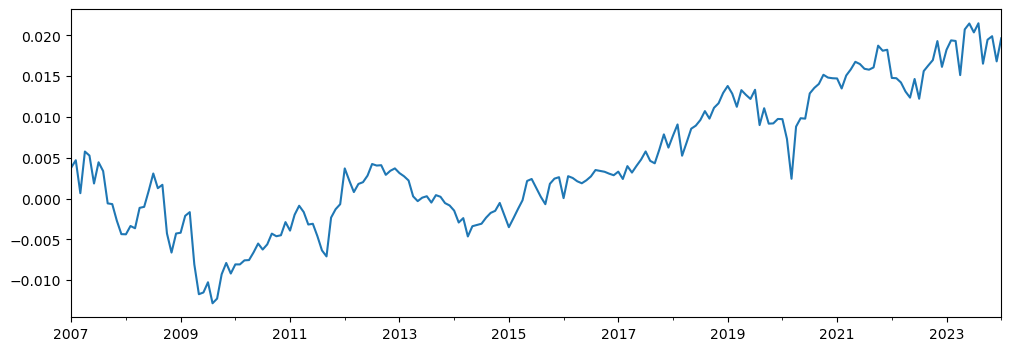

In [27]:
trade_cls = CalcTrade(
    df_price=price,
    init_cap=INIT_CAPITAL,
    adj_small_change=True
)
summary_df = trade_cls.iter_dates(position=position)
summary_df["total_ret"].plot(figsize=(12,4))

In [28]:
df_ff = get_ff_data()

pd.Series({
    **eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12),
    **ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
}) 

return            0.019637
mean              0.000409
std               0.001757
skew             -0.233496
kurtosis          3.558841
sharpe            0.080263
sharpe_mkt        0.012487
sortino           0.100929
var              -0.006704
cvar             -0.012762
max_drawdown     -0.010667
downside_beta    -0.063583
alpha             0.023146
beta_Mkt-RF       0.054455
beta_SMB         -0.001435
beta_HML         -0.521832
beta_RF          81.105239
dtype: float64